In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deixar gráficos bonitos
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [9]:
from google.colab import files

uploaded = files.upload()  # selecione dados_consumo_energia_escritorio.csv

df = pd.read_csv("consumo_home_office_grande.csv")
df.head()

Saving consumo_home_office_grande.csv to consumo_home_office_grande (2).csv


,data,hora_inicio,hora_fim,equipamento,potencia_W
0,2024-01-01,19:00,23:00,PC Gamer,400
1,2024-01-01,19:00,22:00,Monitor,40
2,2024-01-01,20:00,23:00,Ar-condicionado,900
3,2024-01-01,20:00,00:00,Lâmpada LED,10
4,2024-01-01,00:00,00:00,Roteador Wi-Fi,8


In [13]:
# Garantir tipos corretos e criar colunas necessárias
df["data"] = pd.to_datetime(df["data"])

# Criar coluna 'hora' a partir de 'hora_inicio'
df["hora"] = df["hora_inicio"].str[:2].astype(int)

# Converter 'hora_inicio' e 'hora_fim' para datetime, combinando com a coluna 'data'
df['start_dt'] = pd.to_datetime(df['data'].dt.strftime('%Y-%m-%d') + ' ' + df['hora_inicio'])
df['end_dt'] = pd.to_datetime(df['data'].dt.strftime('%Y-%m-%d') + ' ' + df['hora_fim'])

# Ajustar 'end_dt' para eventos que cruzam a meia-noite
# Se 'end_dt' é menor que 'start_dt', significa que o evento termina no dia seguinte
mask_cross_midnight = df['end_dt'] < df['start_dt']
df.loc[mask_cross_midnight, 'end_dt'] += pd.Timedelta(days=1)

# Considerar o caso de '00:00' a '00:00' como 24 horas (comum para equipamentos always-on como roteadores)
mask_24h_case = (df['hora_inicio'] == '00:00') & (df['hora_fim'] == '00:00')
df.loc[mask_24h_case, 'end_dt'] = df.loc[mask_24h_case, 'start_dt'] + pd.Timedelta(days=1)

# Calcular a duração em horas
df['duration_hours'] = (df['end_dt'] - df['start_dt']).dt.total_seconds() / 3600

# Criar coluna 'consumo_kwh' a partir de 'potencia_W' e 'duration_hours'
df["consumo_kwh"] = (df["potencia_W"] * df["duration_hours"]) / 1000

# Adicionar coluna 'area' com um valor padrão, já que não está no CSV original
df['area'] = 'HomeOffice' # Assumindo um único ambiente de home office

# Criar colunas auxiliares
df["dia_semana"] = df["data"].dt.day_name()
df["eh_fim_semana"] = df["data"].dt.weekday >= 5  # sábado/domingo
df["eh_horario_comercial"] = df["hora"].between(8, 19) # 'hora' é a hora de início

# Remover colunas temporárias de cálculo se não forem mais necessárias
df = df.drop(columns=['start_dt', 'end_dt', 'duration_hours'])

df.head()

,data,hora_inicio,hora_fim,equipamento,potencia_W,hora,consumo_kwh,dia_semana,eh_fim_semana,eh_horario_comercial,area
0,2024-01-01,19:00,23:00,PC Gamer,400,19,1.600,Monday,False,True,HomeOffice
1,2024-01-01,19:00,22:00,Monitor,40,19,0.120,Monday,False,True,HomeOffice
2,2024-01-01,20:00,23:00,Ar-condicionado,900,20,2.700,Monday,False,False,HomeOffice
3,2024-01-01,20:00,00:00,Lâmpada LED,10,20,0.040,Monday,False,False,HomeOffice
4,2024-01-01,00:00,00:00,Roteador Wi-Fi,8,0,0.192,Monday,False,False,HomeOffice


Dimensões do dataset: (2190, 10)

Resumo estatístico do consumo (kWh):
count    2190.000000
mean        0.759306
std         1.001897
min         0.015000
25%         0.050000
50%         0.192000
75%         1.600000
max         3.600000
Name: consumo_kwh, dtype: float64

Consumo total no período: 1662.88 kWh

Consumo médio diário: 4.56 kWh/dia


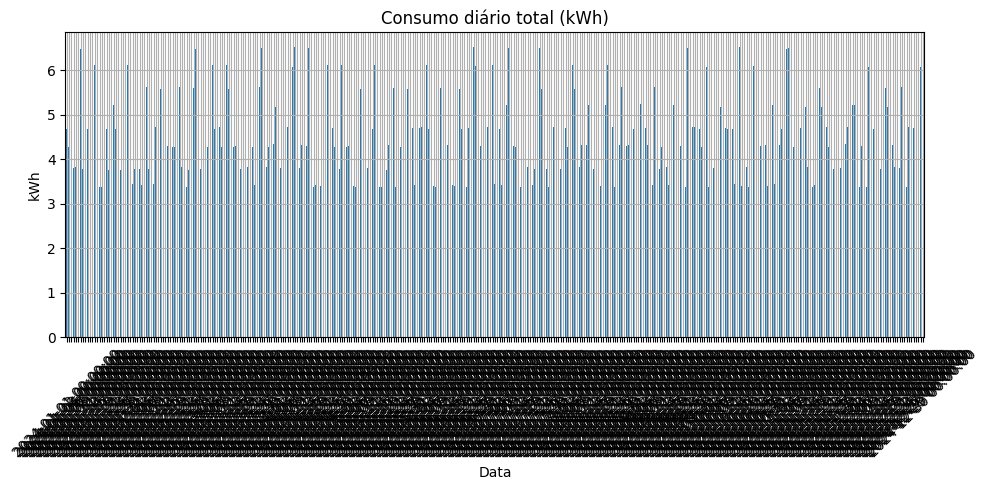

In [11]:
print("Dimensões do dataset:", df.shape)
print("\nResumo estatístico do consumo (kWh):")
print(df["consumo_kwh"].describe())

# Consumo total no período
consumo_total = df["consumo_kwh"].sum()
print(f"\nConsumo total no período: {consumo_total:.2f} kWh")

# Consumo médio por dia
consumo_dia = df.groupby("data")["consumo_kwh"].sum()
print(f"\nConsumo médio diário: {consumo_dia.mean():.2f} kWh/dia")

# Gráfico: consumo diário total
consumo_dia.plot(kind="bar")
plt.title("Consumo diário total (kWh)")
plt.xlabel("Data")
plt.ylabel("kWh")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


area
HomeOffice    1662.88
Name: consumo_kwh, dtype: float64


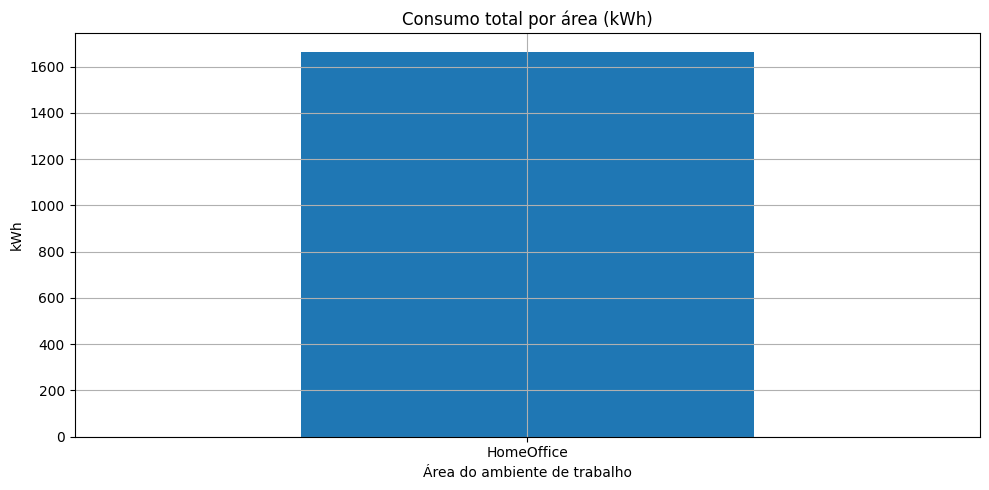

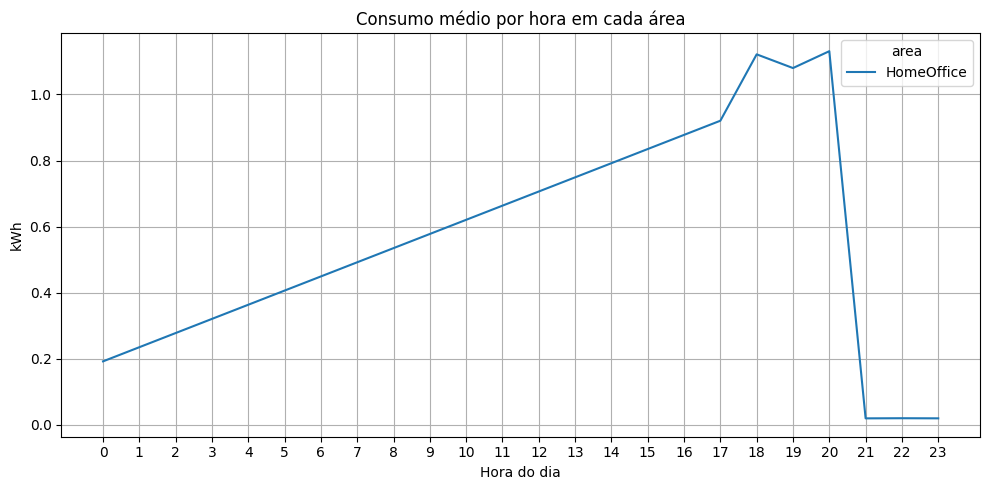

In [14]:
# Consumo total por área
consumo_area = df.groupby("area")["consumo_kwh"].sum().sort_values(ascending=False)
print(consumo_area)

consumo_area.plot(kind="bar")
plt.title("Consumo total por área (kWh)")
plt.xlabel("Área do ambiente de trabalho")
plt.ylabel("kWh")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Consumo médio por hora em cada área (tendência de uso)
consumo_hora_area = df.pivot_table(
    index="hora",
    columns="area",
    values="consumo_kwh",
    aggfunc="mean"
)
consumo_hora_area.plot()
plt.title("Consumo médio por hora em cada área")
plt.xlabel("Hora do dia")
plt.ylabel("kWh")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


Consumo associado a possível desperdício: 954.28 kWh
Isto representa 57.39% do consumo total.


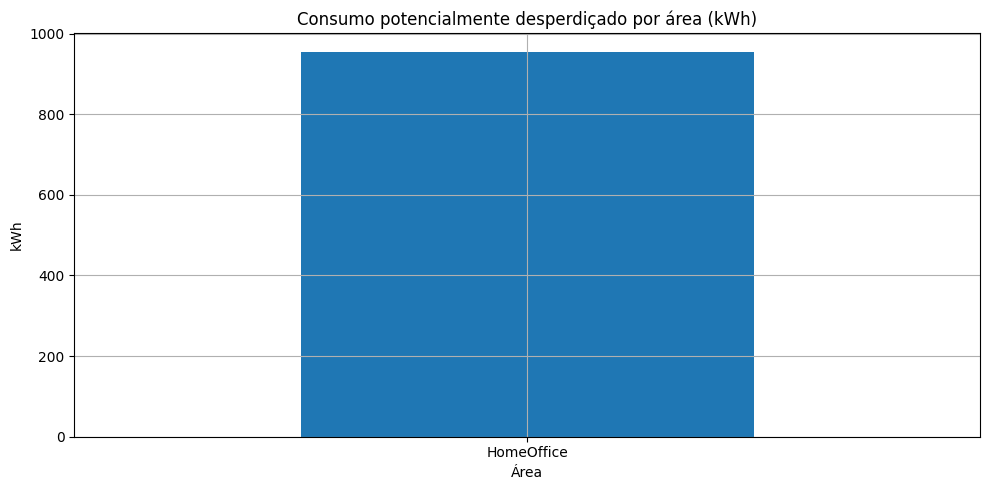

In [15]:
# Filtrar registros considerados desperdício
mask_areas_desperdicio = df["area"].isin(["OpenSpace", "SalasReuniao", "HomeOffice"])

df_desperdicio = df[
    mask_areas_desperdicio &
    (
        (~df["eh_horario_comercial"])  # fora do horário
        | (df["eh_fim_semana"])        # fins de semana
    )
]

consumo_desperdicio = df_desperdicio["consumo_kwh"].sum()
percentual_desperdicio = (consumo_desperdicio / consumo_total) * 100

print(f"Consumo associado a possível desperdício: {consumo_desperdicio:.2f} kWh")
print(f"Isto representa {percentual_desperdicio:.2f}% do consumo total.")

# Gráfico: consumo de desperdício por área
consumo_desperdicio_area = df_desperdicio.groupby("area")["consumo_kwh"].sum()

consumo_desperdicio_area.plot(kind="bar")
plt.title("Consumo potencialmente desperdiçado por área (kWh)")
plt.xlabel("Área")
plt.ylabel("kWh")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [16]:
tarifa_kwh = 0.90  # R$ por kWh (hipotético)
fator_co2 = 0.05   # kg CO2 por kWh (hipotético)
reducao_desperdicio = 0.40  # 40%

economia_kwh = consumo_desperdicio * reducao_desperdicio
economia_reais = economia_kwh * tarifa_kwh
co2_evitar_kg = economia_kwh * fator_co2
co2_evitar_ton = co2_evitar_kg / 1000

print(f"Se reduzirmos 40% do desperdício:")
print(f"- Economia de energia: {economia_kwh:.2f} kWh no período.")
print(f"- Economia financeira: R$ {economia_reais:.2f}.")
print(f"- Emissões evitadas: {co2_evitar_ton:.4f} toneladas de CO₂.")


Se reduzirmos 40% do desperdício:
- Economia de energia: 381.71 kWh no período.
- Economia financeira: R$ 343.54.
- Emissões evitadas: 0.0191 toneladas de CO₂.
